# Save cross-dichroic response to CDP
We import the response values and errors derived in Notebook 4 and save the results in a MIRI MRS CDP format.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
import mrsobs

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# MRS spectral bands (including cross-dichroic configurations)
bands = ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C", 
         "2AxB","2AxC","2BxA","2BxC","2CxA","2CxB",
         "3AxB","3AxC","3BxA","3BxC","3CxA","3CxB",
         "4AxB","4AxC","4BxA","4BxC","4CxA","4CxB"]

cross_bands = ["2AxB","2AxC","2BxA","2BxC","2CxA","2CxB",
               "3AxB","3AxC","3BxA","3BxC","3CxA","3CxB",
               "4AxB","4AxC","4BxA","4BxC","4CxA","4CxB"]

# load spectrophotometric responses derived Notebook 4
response = funcs.load_obj('cross_dichroic_response')
response_err = funcs.load_obj('cross_dichroic_response_error')

In [3]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
dichroicDir   = workDir+'MRSWaveCal/MrsFilterTransmissions/'
lvl2path  = workDir+'FM_data/LVL2/'

# Populate dictionaries with the wavelength, pixel size, validity maps, and latest spectrophotometric CDP data
# (corresponding to the detector plane)

sliceMap   = {}
sizeMap    = {}
validMap   = {}
lambdaMap  = {}
photom     = {}
photom_err = {}
photom_dq  = {}

for band in bands:
    if len(band) == 4:
        # cross-dichroic configuration
        continue
    # print "Band {}".format(band)
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    sliceMap[band]  = d2cMaps['sliceMap']
    lambdaMap[band] = d2cMaps['lambdaMap']
    sizeMap[band]   = funcs.get_pixel_spatial_area(band=band,d2cMaps=d2cMaps)
    
    # create a "valid" map with all the pixels inside the slices of a particular band
    channel = int(band[0])
    # slice numbers in the slice map of the distortion CDP for this band
    sliceInventory = np.unique(sliceMap[band])
    slicesInBand = sliceInventory[np.where( (sliceInventory >= 100*channel ) & (sliceInventory <100*(channel+1)))]
    
    validMap[band] = np.zeros(sliceMap[band].shape)
    for ss in slicesInBand:
        s = int(ss - 100*channel)
        # construct a list of y,x coordinates of detector pixels belonging to slices of this band
        pixels = np.where(sliceMap[band] == ss)
        validMap[band][pixels] = 1
    
    # latest spectrophotometric calibration data product
    photom[band] = funcs.get_cdps(band,cdpDir)[1]
    photom_err[band] = fits.open(funcs.get_cdps(band,cdpDir,output='filepath')[1])[2].data
    photom_dq[band]  = fits.open(funcs.get_cdps(band,cdpDir,output='filepath')[1])[3].data

Let's plot 1d spectra of the response values and errors. The nominal PHOTOM CDP values and errors are overplotted in black.

<IPython.core.display.Javascript object>


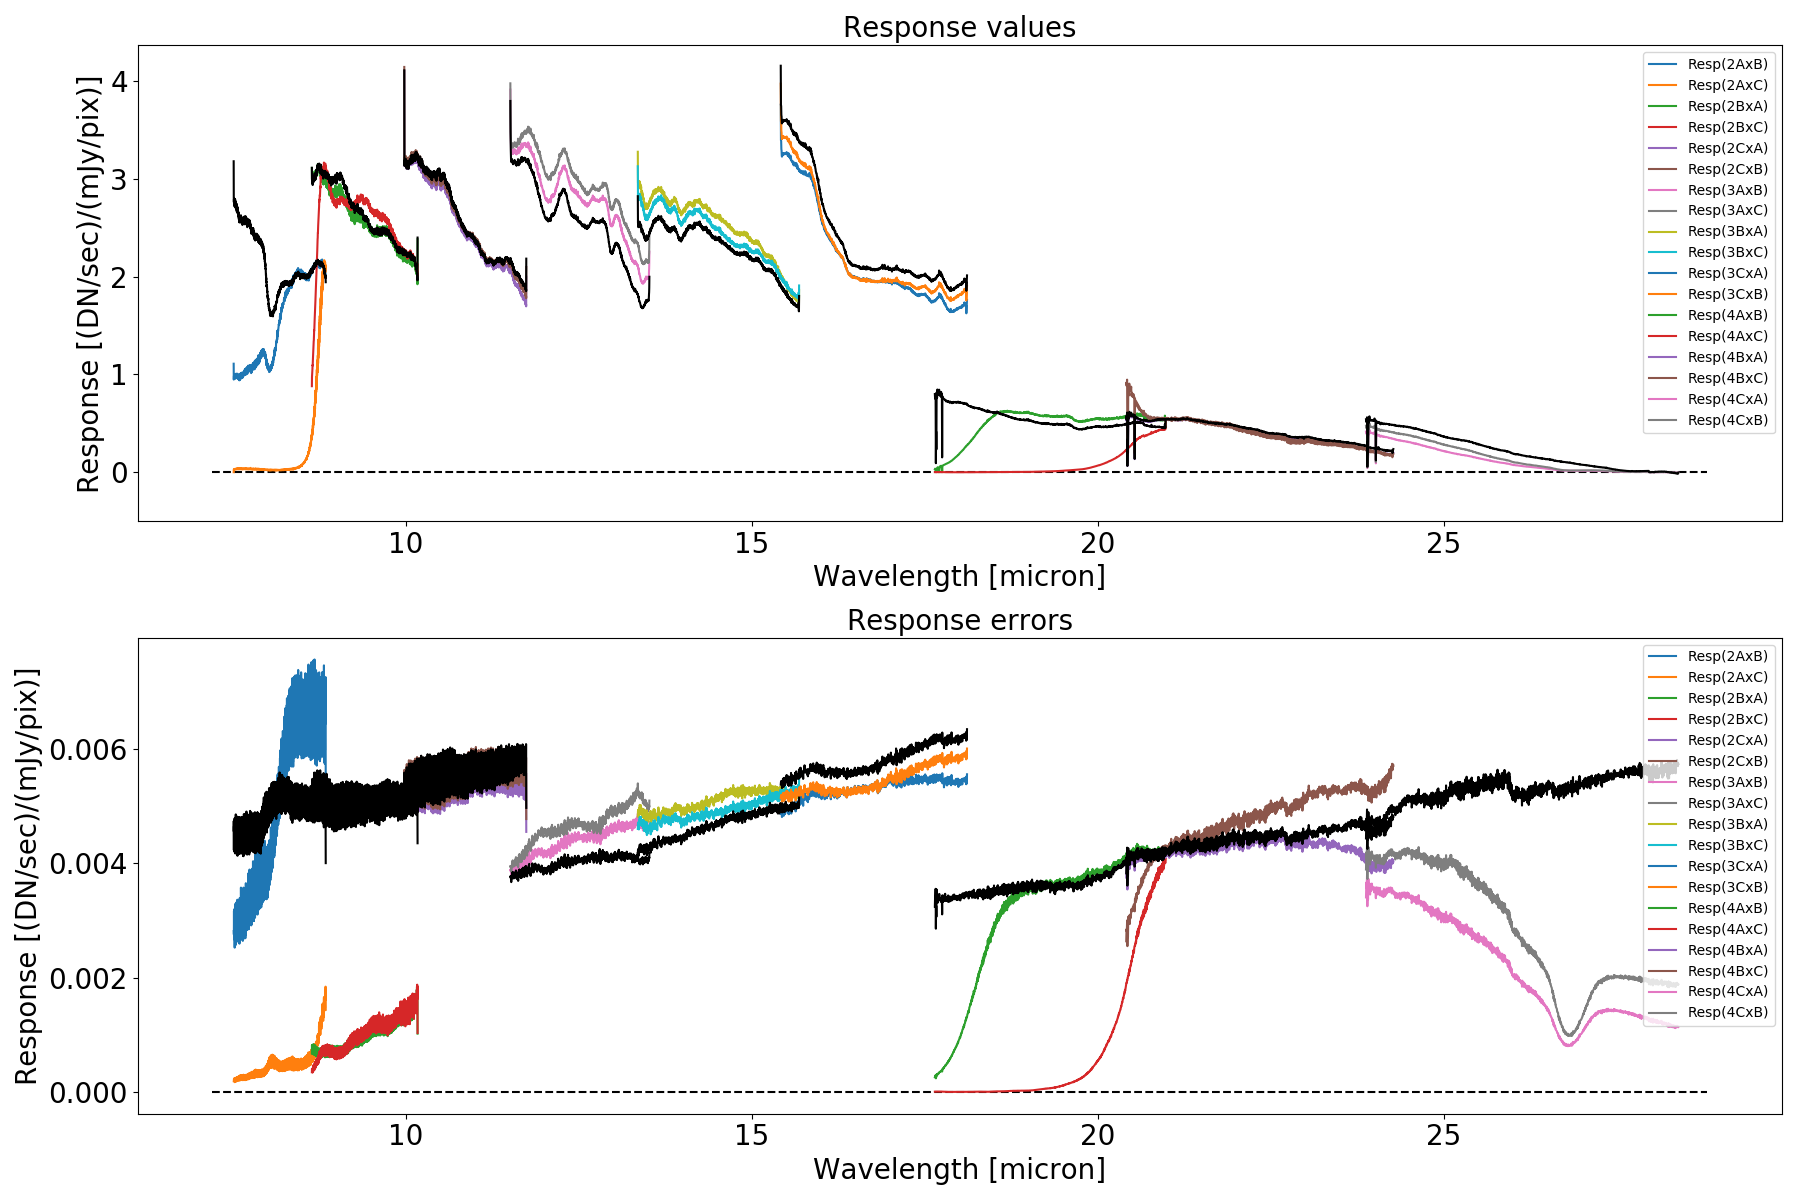

In [21]:
fig,axs = plt.subplots(2,1,figsize=(18,12))
axs[0].set_title('Response values')
axs[1].set_title('Response errors')
for band in cross_bands:
    if band[0] in ['2','3']:
        axs[0].plot(lambdaMap[band[:2]][:,537],(response[band])[:,537],label='Resp({})'.format(band))
        axs[1].plot(lambdaMap[band[:2]][:,537],(response_err[band])[:,537],label='Resp({})'.format(band))
    if band[0] == '4':
        axs[0].plot(lambdaMap[band[:2]][:,47],(response[band])[:,47],label='Resp({})'.format(band))
        axs[1].plot(lambdaMap[band[:2]][:,47],(response_err[band])[:,47],label='Resp({})'.format(band))
for band in bands:
    if len(band) == 4:
        continue
    if band[0] in ['2','3']:
        axs[0].plot(lambdaMap[band][:,537],(photom[band])[:,537],'k')
        axs[1].plot(lambdaMap[band][:,537],(photom_err[band])[:,537],'k')
    if band[0] == '4':
        axs[0].plot(lambdaMap[band][:,47],(photom[band])[:,47],'k')
        axs[1].plot(lambdaMap[band][:,47],(photom_err[band])[:,47],'k')
axs[0].set_ylim(-0.5)
for plot in range(2):
    axs[plot].hlines(0,7.2,28.8,linestyle='dashed')
    axs[plot].legend(fontsize=10,)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Response [(DN/sec)/(mJy/pix)]')
plt.tight_layout()

In [4]:
# save responses to CDP
oldCdp = fits.open(cdpDir+"MIRI_FM_MIRIFUSHORT_SHORT_PHOTOM_06.03.02.fits")
dq_def = oldCdp[4]

In [5]:
outDir = cdpDir+"CDP7/"

In [6]:
def makeHeader(detector, channel, DGAA, DGAB, band):
    hdu0 = fits.PrimaryHDU()
    hdu0.header["TELESCOP"]="JWST"
    hdu0.header["INSTRUME"]="MIRI"
    hdu0.header["MODELNAM"]=("FM", "Instrument model name")
    hdu0.header["DETECTOR"]=detector
    hdu0.header["DETSETNG"]="ANY"
    hdu0.header["READPATT"]="ANY"
    hdu0.header["SUBARRAY"]="GENERIC"
    hdu0.header["SUBSTRT1"]= 1                                            
    hdu0.header["SUBSIZE1"]= 1032                                              
    hdu0.header["SUBSTRT2"]= 1                                                
    hdu0.header["SUBSIZE2"]= 1024                                           
    hdu0.header["FASTAXIS"]= 1                                               
    hdu0.header["SLOWAXIS"]= 2
    hdu0.header["PHOTMJSR"]= 42.5
    hdu0.header["PHOTUJA2"]= 1000.0
    hdu0.header["CHANNEL"] = channel
    hdu0.header["BAND"]    = band
    hdu0.header["DGAA"]    = DGAA
    hdu0.header["DGAB"]    = DGAB
    hdu0.header["FILENAME"]= "MIRI_FM_"+detector+"_"+channel+band+"_PHOTOM_7B.00.00.fits"
    hdu0.header["DATE"]="2018-06-07"
    hdu0.header["VERSION"] ="7B.03.00"
    hdu0.header["USEAFTER"] ="2000-01-01T00:00:00"
    hdu0.header["AUTHOR"]  ="Bart Vandenbussche"
    hdu0.header["ORIGIN"]  = "MIRI European Consortium"
    hdu0.header["EXP_TYPE"]= "MIR_MRS"
    hdu0.header["REFTYPE"] ="PHOTOM"
    hdu0.header["DESCRIP"] = 'CDP-7 MIRI MRS response'
    hdu0.header["PEDIGREE"] = 'GROUND'
    hdu0.header.add_history("DOCUMENT: MIRI-TN-00002-KUL Draft C")
    hdu0.header.add_history("SOFTWARE: MIRICLE ")
    hdu0.header.add_history("DATA USED: RAL FM data obsId 12688")
    return hdu0

In [7]:
# save outputs
detector  = "MIRIFUSHORT"
if detector[6:] == 'SHORT':  channel = '12'
elif detector[6:] == 'LONG': channel = '34'
DGAA,DGAB = 'MEDIUM','SHORT'
band      = DGAA+DGAB
hdu0 = makeHeader(detector, channel, DGAA, DGAB, band)

resp,err,size = [np.full((1024,1032),np.nan) for i in range(3)]

sel = (validMap["1B"]==1)
resp[sel] = photom["1B"][sel]
err[sel]  = photom_err["1B"][sel]
size[sel] = sizeMap["1B"][sel]

sel = (validMap['2A']==1)
resp[sel] = response['2AxB'][sel]
err[sel]  = response_err['2AxB'][sel]
size[sel] = sizeMap['2A'][sel]

dq = photom_dq['2A'].copy()

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_{}_{}{}_PHOTOM_7B.00.00.fits".format(detector,channel,band),overwrite=True)

In [8]:
# save outputs
detector  = "MIRIFULONG"
if detector[6:] == 'SHORT':  channel = '12'
elif detector[6:] == 'LONG': channel = '34'
DGAA,DGAB = 'MEDIUM','SHORT'
band      = DGAA+DGAB
hdu0 = makeHeader(detector, channel, DGAA, DGAB, band)

resp,err,size = [np.full((1024,1032),np.nan) for i in range(3)]

sel = (validMap["3A"]==1)
resp[sel] = response["3AxB"][sel]
err[sel]  = response_err["3AxB"][sel]
size[sel] = sizeMap["3A"][sel]

sel = (validMap['4B']==1)
resp[sel] = response['4BxA'][sel]
err[sel]  = response_err['4BxA'][sel]
size[sel] = sizeMap['4B'][sel]

dq = photom_dq['4B'].copy()

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_{}_{}{}_PHOTOM_7B.00.00.fits".format(detector,channel,band),overwrite=True)

In [9]:
# save outputs
detector  = "MIRIFUSHORT"
if detector[6:] == 'SHORT':  channel = '12'
elif detector[6:] == 'LONG': channel = '34'
DGAA,DGAB = 'LONG','SHORT'
band      = DGAA+DGAB
hdu0 = makeHeader(detector, channel, DGAA, DGAB, band)

resp,err,size = [np.full((1024,1032),np.nan) for i in range(3)]

sel = (validMap["1C"]==1)
resp[sel] = photom["1C"][sel]
err[sel]  = photom_err["1C"][sel]
size[sel] = sizeMap["1C"][sel]

sel = (validMap['2A']==1)
resp[sel] = response['2AxC'][sel]
err[sel]  = response_err['2AxC'][sel]
size[sel] = sizeMap['2A'][sel]

dq = photom_dq['2A'].copy()

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_{}_{}{}_PHOTOM_7B.00.00.fits".format(detector,channel,band),overwrite=True)

In [10]:
# save outputs
detector  = "MIRIFULONG"
if detector[6:] == 'SHORT':  channel = '12'
elif detector[6:] == 'LONG': channel = '34'
DGAA,DGAB = 'LONG','SHORT'
band      = DGAA+DGAB
hdu0 = makeHeader(detector, channel, DGAA, DGAB, band)

resp,err,size = [np.full((1024,1032),np.nan) for i in range(3)]

sel = (validMap["3A"]==1)
resp[sel] = response["3AxC"][sel]
err[sel]  = response_err["3AxC"][sel]
size[sel] = sizeMap["3A"][sel]

sel = (validMap['4C']==1)
resp[sel] = response['4CxA'][sel]
err[sel]  = response_err['4CxA'][sel]
size[sel] = sizeMap['4C'][sel]

dq = photom_dq['4C'].copy()

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_{}_{}{}_PHOTOM_7B.00.00.fits".format(detector,channel,band),overwrite=True)

In [11]:
# save outputs
detector  = "MIRIFUSHORT"
if detector[6:] == 'SHORT':  channel = '12'
elif detector[6:] == 'LONG': channel = '34'
DGAA,DGAB = 'SHORT','MEDIUM'
band      = DGAA+DGAB
hdu0 = makeHeader(detector, channel, DGAA, DGAB, band)

resp,err,size = [np.full((1024,1032),np.nan) for i in range(3)]

sel = (validMap["1A"]==1)
resp[sel] = photom["1A"][sel]
err[sel]  = photom_err["1A"][sel]
size[sel] = sizeMap["1A"][sel]

sel = (validMap['2B']==1)
resp[sel] = response['2BxA'][sel]
err[sel]  = response_err['2BxA'][sel]
size[sel] = sizeMap['2B'][sel]

dq = photom_dq['2B'].copy()

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_{}_{}{}_PHOTOM_7B.00.00.fits".format(detector,channel,band),overwrite=True)

In [12]:
# save outputs
detector  = "MIRIFULONG"
if detector[6:] == 'SHORT':  channel = '12'
elif detector[6:] == 'LONG': channel = '34'
DGAA,DGAB = 'SHORT','MEDIUM'
band      = DGAA+DGAB
hdu0 = makeHeader(detector, channel, DGAA, DGAB, band)

resp,err,size = [np.full((1024,1032),np.nan) for i in range(3)]

sel = (validMap["3B"]==1)
resp[sel] = response["3BxA"][sel]
err[sel]  = response_err["3BxA"][sel]
size[sel] = sizeMap["3B"][sel]

sel = (validMap['4A']==1)
resp[sel] = response['4AxB'][sel]
err[sel]  = response_err['4AxB'][sel]
size[sel] = sizeMap['4A'][sel]

dq = photom_dq['4A'].copy()

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_{}_{}{}_PHOTOM_7B.00.00.fits".format(detector,channel,band),overwrite=True)

In [13]:
# save outputs
detector  = "MIRIFUSHORT"
if detector[6:] == 'SHORT':  channel = '12'
elif detector[6:] == 'LONG': channel = '34'
DGAA,DGAB = 'LONG','MEDIUM'
band      = DGAA+DGAB
hdu0 = makeHeader(detector, channel, DGAA, DGAB, band)

resp,err,size = [np.full((1024,1032),np.nan) for i in range(3)]

sel = (validMap["1C"]==1)
resp[sel] = photom["1C"][sel]
err[sel]  = photom_err["1C"][sel]
size[sel] = sizeMap["1C"][sel]

sel = (validMap['2B']==1)
resp[sel] = response['2BxC'][sel]
err[sel]  = response_err['2BxC'][sel]
size[sel] = sizeMap['2B'][sel]

dq = photom_dq['2B'].copy()

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_{}_{}{}_PHOTOM_7B.00.00.fits".format(detector,channel,band),overwrite=True)

In [14]:
# save outputs
detector  = "MIRIFULONG"
if detector[6:] == 'SHORT':  channel = '12'
elif detector[6:] == 'LONG': channel = '34'
DGAA,DGAB = 'LONG','MEDIUM'
band      = DGAA+DGAB
hdu0 = makeHeader(detector, channel, DGAA, DGAB, band)

resp,err,size = [np.full((1024,1032),np.nan) for i in range(3)]

sel = (validMap["3B"]==1)
resp[sel] = response["3BxC"][sel]
err[sel]  = response_err["3BxC"][sel]
size[sel] = sizeMap["3B"][sel]

sel = (validMap['4C']==1)
resp[sel] = response['4CxB'][sel]
err[sel]  = response_err['4CxB'][sel]
size[sel] = sizeMap['4C'][sel]

dq = photom_dq['4C'].copy()

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_{}_{}{}_PHOTOM_7B.00.00.fits".format(detector,channel,band),overwrite=True)

In [15]:
# save outputs
detector  = "MIRIFUSHORT"
if detector[6:] == 'SHORT':  channel = '12'
elif detector[6:] == 'LONG': channel = '34'
DGAA,DGAB = 'SHORT','LONG'
band      = DGAA+DGAB
hdu0 = makeHeader(detector, channel, DGAA, DGAB, band)

resp,err,size = [np.full((1024,1032),np.nan) for i in range(3)]

sel = (validMap["1A"]==1)
resp[sel] = photom["1A"][sel]
err[sel]  = photom_err["1A"][sel]
size[sel] = sizeMap["1A"][sel]

sel = (validMap['2C']==1)
resp[sel] = response['2CxA'][sel]
err[sel]  = response_err['2CxA'][sel]
size[sel] = sizeMap['2C'][sel]

dq = photom_dq['2C'].copy()

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_{}_{}{}_PHOTOM_7B.00.00.fits".format(detector,channel,band),overwrite=True)

In [16]:
# save outputs
detector  = "MIRIFULONG"
if detector[6:] == 'SHORT':  channel = '12'
elif detector[6:] == 'LONG': channel = '34'
DGAA,DGAB = 'SHORT','LONG'
band      = DGAA+DGAB
hdu0 = makeHeader(detector, channel, DGAA, DGAB, band)

resp,err,size = [np.full((1024,1032),np.nan) for i in range(3)]

sel = (validMap["3C"]==1)
resp[sel] = response["3CxA"][sel]
err[sel]  = response_err["3CxA"][sel]
size[sel] = sizeMap["3C"][sel]

sel = (validMap['4A']==1)
resp[sel] = response['4AxC'][sel]
err[sel]  = response_err['4AxC'][sel]
size[sel] = sizeMap['4A'][sel]

dq = photom_dq['4A'].copy()

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_{}_{}{}_PHOTOM_7B.00.00.fits".format(detector,channel,band),overwrite=True)

In [17]:
# save outputs
detector  = "MIRIFUSHORT"
if detector[6:] == 'SHORT':  channel = '12'
elif detector[6:] == 'LONG': channel = '34'
DGAA,DGAB = 'MEDIUM','LONG'
band      = DGAA+DGAB
hdu0 = makeHeader(detector, channel, DGAA, DGAB, band)

resp,err,size = [np.full((1024,1032),np.nan) for i in range(3)]

sel = (validMap["1B"]==1)
resp[sel] = photom["1B"][sel]
err[sel]  = photom_err["1B"][sel]
size[sel] = sizeMap["1B"][sel]

sel = (validMap['2C']==1)
resp[sel] = response['2CxB'][sel]
err[sel]  = response_err['2CxB'][sel]
size[sel] = sizeMap['2C'][sel]

dq = photom_dq['2C'].copy()

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_{}_{}{}_PHOTOM_7B.00.00.fits".format(detector,channel,band),overwrite=True)

In [18]:
# save outputs
detector  = "MIRIFULONG"
if detector[6:] == 'SHORT':  channel = '12'
elif detector[6:] == 'LONG': channel = '34'
DGAA,DGAB = 'MEDIUM','LONG'
band      = DGAA+DGAB
hdu0 = makeHeader(detector, channel, DGAA, DGAB, band)

resp,err,size = [np.full((1024,1032),np.nan) for i in range(3)]

sel = (validMap["3C"]==1)
resp[sel] = response["3CxB"][sel]
err[sel]  = response_err["3CxB"][sel]
size[sel] = sizeMap["3C"][sel]

sel = (validMap['4B']==1)
resp[sel] = response['4BxC'][sel]
err[sel]  = response_err['4BxC'][sel]
size[sel] = sizeMap['4B'][sel]

dq = photom_dq['4B'].copy()

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_{}_{}{}_PHOTOM_7B.00.00.fits".format(detector,channel,band),overwrite=True)